# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
data.info()
print(f'\nincome distinct data: {data["income"].unique()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB

income distinct data: ['<=50K' '>50K']


In [3]:
# TODO: Total number of records
n_records = np.max(data.count())

# TODO: Number of records where individual's income is more than $50,000
# I could use df.size as well.. but getting the max of df's count makes more sense
n_greater_50k = np.max(data[data['income'].str.contains('>')].count())

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = np.max(data[data['income'].str.contains('<=')].count())
# or maybe: just n-records - n_greater_50k if len(data['income'].unique()) == 2 else 'nope'

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent*100))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

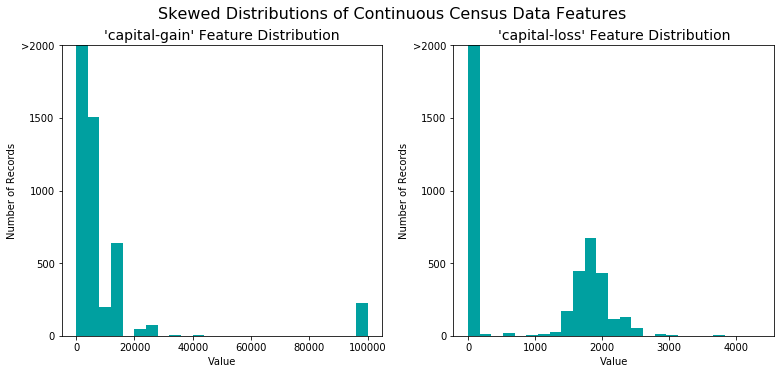

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

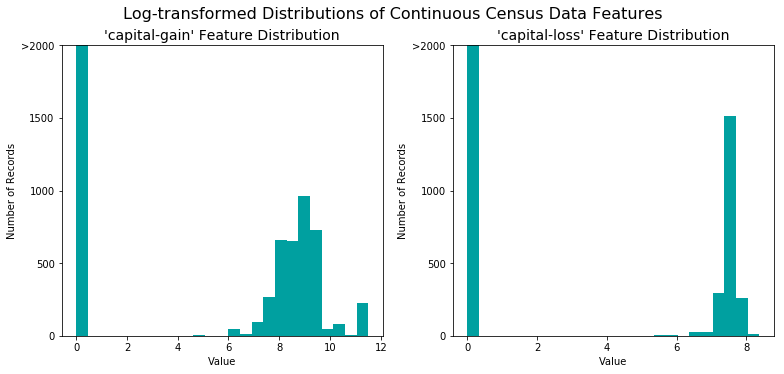

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# We could dynamically find those columns that should be normalized
print(features_raw.dtypes)
numeric_columns = features_raw.select_dtypes(include=[np.number]).columns
numeric_columns

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
dtype: object


Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.'

In [8]:
# Just as seen before, we can select columns based on its datatype
categorical_features = features_log_minmax_transform.select_dtypes('object').columns

# Let'see that categorical data to make sure we're not making mistakes
display(categorical_features)
display(features_log_minmax_transform[categorical_features].head())

Index(['workclass', 'education_level', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

,workclass,education_level,marital-status,occupation,relationship,race,sex,native-country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [9]:
# Bonus: It makes sense to transform that data to category data?
# Well, we're encoding them into numbers, so it really doesn't.
# But since we're here, let's analyze what that transformation does to the data storage
obj_size = np.sum(features_log_minmax_transform[categorical_features].memory_usage())
cat_size = np.sum(features_log_minmax_transform[categorical_features].astype('category').memory_usage())

memo = pd.DataFrame({'bytes': [obj_size, cat_size] }, index=['object', 'category'])
display(memo)
print('o dado to tipo "object" custa {:.1f} vezes mais que um do tipo "category"'.format(obj_size/cat_size))

# If we need to transform it, that's how we'd do it:
# features_log_minmax_transform[categorical_features].astype('category', inplace=True)

,bytes
object,2894288
category,366240


o dado to tipo "object" custa 7.9 vezes mais que um do tipo "category"


In [10]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = data['income'].map(lambda i: 0 if i.__contains__('<') else 1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding. (before there were only {})".format(len(encoded), len(features_raw.columns)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding. (before there were only 13)


In [11]:
features_final.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [12]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \\$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

**HINT:** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [13]:
# We are naively assuming that EVERYONE ON THE DATASET makes $50k+
# One reason to do that is to evaluate how well our evaluation metrics are behaving.
N = income.count()
TP = np.sum(income)
FP = N - TP # todos aqueles que não ganham mais de 50k (que previmos que ganhassem)
FN = 0
TN = 0

In [14]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = TP/N
recall = TP/(TP+FN)
precision = TP/(TP+FP)

beta = 0.5
# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+(beta ** 2))*(precision*recall)/(((beta ** 2)*precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

#### Determinando as propriedades do conjunto de dados

Curioso à respeito da proporção, do conjunto de treino, das classes:

In [15]:
print(f'Um vetor de entrada qualquer, x_i, tem {len(features_final.columns)} dimensões')
print(f'É um problema de classificação de {len(income.unique())} classes: {income.unique()}')

Um vetor de entrada qualquer, x_i, tem 103 dimensões
É um problema de classificação de 2 classes: [0 1]


In [16]:
print(f'Percentual de categorizações 0: {y_train[y_train == 0].size/y_train.size}')
print(f'Percentual de categorizações 1: {y_train[y_train == 1].size/y_train.size}')

Percentual de categorizações 0: 0.7511402272161871
Percentual de categorizações 1: 0.2488597727838129


É evidente um desblanceamento: Apenas 25% do conjunto de treino têm um faturamento superior à $50k/ano

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**HINT:**

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer:**

Since we're dealing with a binary classification and with a high-dimension input space, I've chosen the following models:

1. Logistic Regression
2. Support Vector Machines
3. Ensemble Methods (Random Forest)

### 1. Logistic Regression

- Describe one real-world application in industry where the model can be applied.

Linear Regression is one of the most exploited statistical methods in modeling company growth, financial distress, success, and similar outcomes[1].

- What are the strengths of the model; when does it perform well?

The advantages are:
1. Logistic regression not only says where the boundary between the two classes is, but also says that the class probabilities depend on distance from the boundary. In order words, it outputs the *probability* of the input belonging to a certain class[3] instead of just the predicted class,
2. It's a flexible technique: doesn't require assumptions such as normal distribution of independent variables, linearity and equality of variance-covariance matrix[2] and
3. It can be easily explained since the obtained coefficients are directly related to the independent variables, making clear which ones are mostly influencing the output.


- What are the weaknesses of the model; when does it perform poorly?

The weaknesses are:
1. It should be used on relatively large datasets, as in estimations by low numbers of observations, reliability of the model decreases[2],
2. It is required to be little or no multicollinearity among the independent variables i.e. the independent variable shouldn't be highly correlated with each other[4]. Although it *does* assumes a linear relationship between the log-odds of the dependent variable to the independent variables.

- What makes this model a good candidate for the problem, given what you know about the data?

It makes a good candidate because it describes how strong each weight is impacting on the prediction, which gives more confidence on using the model. It's a specialized binary classification model. Data set sparsity could be handled by using  `L1 Regularization`, which is in some sense a kind of feature selection so it's a positive: the model is less likely to overfit. Also, our data is relatively small so the training time shouldn't be a problem.

[1]: Marijana Zekić-Sušac1, Nataša Šarlija1, Adela Has and Ana Bilandžić, "*Predicting company growth using logistic regression and neural networks*". [URL](https://hrcak.srce.hr/file/257100)

[2]: Ömay ÇOKLUK, "*Logistic Regression: Concept and Application*". [URL](https://files.eric.ed.gov/fulltext/EJ919857.pdf)

[3]: Julian Faraway, "*Linear Models with R: Chapter 12*" [URL](https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf)

[4]: "*Assumptions of Logistic Regression*". [URL](https://www.statisticssolutions.com/assumptions-of-logistic-regression/)

### 2. Support Vector Machines

- Describe one real-world application in industry where the model can be applied.

Support vector machines can be used in a wide variety of applications: from text classification[1] to credit rating analysis[2]

- What are the strengths of the model; when does it perform well?

The advantages are:

1. Use of kernels i.e.
 - Kernels are functions that quantify similarities between observations. So kernels are used to enlarge (transform) the feature space in order to accomodate a non-linear boundary between the classes.[3] Trivial example: data points that are hardly separated in 2D space can be easily separated in 3D space
2. Absence of local minima, i.e. it is defined by a quadratic optimization problem[4] not greedy search optimization problem
3. Capacity control obtained by optimising (maximizing) the margin[4]


- What are the weaknesses of the model; when does it perform poorly?

The weaknesses are:
1. It requires large training times for large datasets, since the memory needed to store the kernel matrix scales **quadratically** to the number of data points[5],
2. The problem must be formulated as a binary classification
3. It is difficult to interpret and understand the *weights* produced by the decision function. So it's difficult to explain in business terms the relevance and importance of features


- What makes this model a good candidate for the problem, given what you know about the data?

It makes a good candidate because it performs well on sparse data sets[6], which is our own (due to feature encoding). Although it is computationally expensive, when using linear kernel function on relatively small data sets (which is our own), fitting the data shouldn't be a concern.

[1]: Thorsten Joachims, "*Text categorization with Support Vector Machines: Learning with many relevant features*". [URL](https://link.springer.com/chapter/10.1007%2FBFb0026683?LI=true)

[2]: Zan Huanga, Hsinchun Chena, Chia-Jung Hsua, Wun-Hwa Chenb, Soushan Wuc, "*Credit rating analysis with support vector machines and neural networks: a market comparative study*". [URL](http://www.svms.org/finance/Huang-etal2004.pdf)

[3]: Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani, "*An Introduction to Statistical Learning*" [URL](https://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf)

[4]: "*An Idiot's Guide to SVMs*". [URL](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf)

[5]: "*Can support vector machine be used in large data?*" [URL](https://stats.stackexchange.com/questions/314329/can-support-vector-machine-be-used-in-large-data)

[6]: "Data Sparseness in Linear SVM" [URL](https://www.ijcai.org/Proceedings/15/Papers/510.pdf)

###  3. Gradient Boost (Tree boosting)

- Describe one real-world application in industry where the model can be applied.

It is widely used in *anomaly detection* applications such as credit fraud, DNA sequencing, namely classification problems where the positive case is sparse (unbalanced).[1]


- What are the strengths of the model; when does it perform well?


1. It performs the optimization on the *loss function space*, which makes it flexible on which function to use (rather than on the typical *feature space* optimization)[1]
2. Boosting focuses on a step by step residual reduction, strengthening the impact of positive classes[1]
3. By using a bagging technique, significantly reduces the overfit behaviour of weak learners[1]


- What are the weaknesses of the model; when does it perform poorly?

1. Since it's built sequentially over running residuals, it can be computationally expensive depending on hyper-parameters chosen and sample size used
2. May have significant variance and prone to overfitting if the data set has too many noise


- What makes this model a good candidate for the problem, given what you know about the data?

Decision tree is a method of drawing complex non-linear ways of categorizing the data set. It has a few drawbacks being the main one its easiness of overfitting, i.e. being very accurate on the data it has been trained but doesn't generalize on unseen data. This can be significantly minimized using some techniques, one being *bagging*, which is implemented by Boosting Trees algorithms. It is especially fit for this problem since it performs well on sparse data sets. It also strengthen the predictive power of unbalanced positive classes, by nature of the boosting technique, which is also the case of our data set (as noted above).

[1] "*Efficient top rank optimization with gradient boosting for supervised anomaly detection*"
 [URL](http://ecmlpkdd2017.ijs.si/papers/paperID241.pdf)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [17]:
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
LinearSVC trained on 361 samples.
LinearSVC trained on 3617 samples.
LinearSVC trained on 36177 samples.
XGBClassifier trained on 361 samples.


/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

XGBClassifier trained on 3617 samples.


/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier trained on 36177 samples.


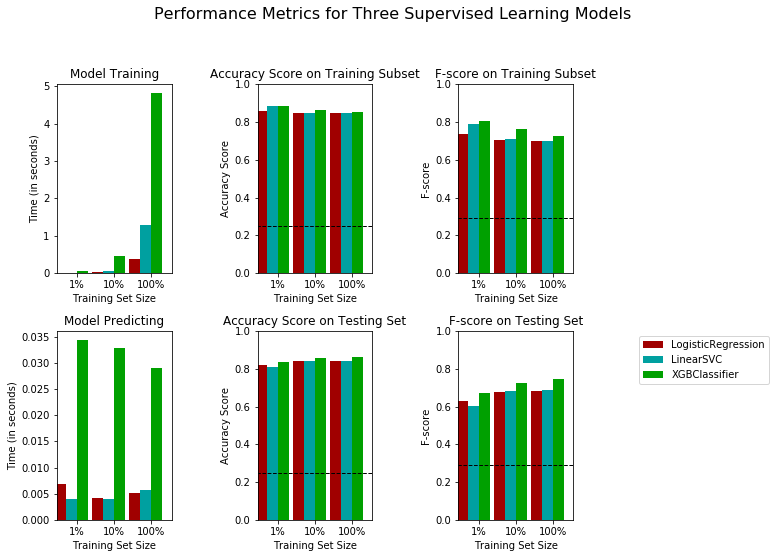

In [18]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=0)
clf_B = LinearSVC(random_state=0)
# clf_C = GradientBoostingClassifier(random_state=0)
clf_C = XGBClassifier(random_state=0, n_jobs=3)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

In [19]:
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    print(f'{clf_name}: {results[clf_name][2]["f_test"]}')

LogisticRegression: 0.6831652282416554
LinearSVC: 0.6855643044619422
XGBClassifier: 0.7435430651951304


### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

**HINT:** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer**

Dear Mr. or Mrs. Responsible for the project, we've benchmarked and compared three potential candidates for modeling this problem. Our chosen metric for selecting the model rewards the one who achieves more *precision*. You can think of precision as, if you think of a game of darts, having the darts shot very closely to each other. It's important to note that, in this example, the precision (or any other metric) is given in terms of the **amount of total darts thrown** and **how many of them stick closely together**. 

We pick Gradient Boost because it outperformed our other two potential choices. Although it was the one that took longer to train, it's a worthy trade-off in this case since our dataset is relatively small. The reason for its performance is due to the way the technique is implemented: it leverages certain characteristics that specifically fit our dataset (such as a high dimensional sparse feature space and an unbalanced label space).

**Understanding the coefficients** (_Not really part of the answer but part of my understanding of the results_)

**Even though I'm not using Logistic Regression anymore, I found this analysis useful so I'm leaving it here for future reference**.

The coefficients calculated from the `LogisticRegression` represents the logarithm of the odds of that weight contributing to a positive classification (1)

The following shows the odds of each feature in classifying a person as having a salary greater than $50k. For example, the odds of a person who has a doctorate degree (`education_level_ Doctorate`) also earn more than \\$50k a year, according to the model, is 8.36 to 1.

The definition of probability in terms of odds is

$$ \text{probability} = \frac{\text{odds}}{\text{1 + odds}} $$

So in that example, the probability of a prediction that person who has a doctorate degree is also earning more than \\$50k a year is ~89%

In [20]:
# feature_odds = list(zip(X_train.columns, np.exp(clf_A.coef_[0])))
# feature_odds

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**HINT:**

When explaining your model, if using external resources please include all citations.

**Answer:**

To understand thoroughly the concept behind the chosen model, we must cover three basics concepts: 

**Decision Trees**

We start out with a dataset that has 36177 persons, each one is described by 103 features (features being age, education level, etc). In this dataset we also know if each of those persons earns more or less than \\$50k/year, that's the thing we're trying to predict. We then feed our model this dataset in order to establish a relationship between those features and the thing we're trying to predict. This is called *training*: we're training our model to this specific dataset. During trainin, the model tries to sequentially split our dataset in two. For example, it might split people who have a doctorate degree and people who doesn't. And we keep splitting in two, just as in a tree branching fashion. Since our dataset is defined by 103 features (and not a few), that are *many ways* this splitting can be done.

**Bagging**

Now imagine for a second that we found the best way to split this dataset. Since we've lots of features, it most probably did the best split for *this specific dataset we fed it*, i.e. if we feed new data, it wouldn't be able to classify correctly (because it has never seen it). What if, instead of just one tree, that's highly specialized in a specific dataset, we could create a variety of trees? That's the idea behind a *bag of trees*. 

**Boosting**

Returning to that base tree model that's highly specialized in our training dataset. Since we know the correct classifications, suppose we calculate how many errors it has made. The concept behind boosting is to use theses errors as data to create more trees so our model correct for these errors. How so? We use those trees in a way to draw a relationship between the features we have and the errors we have, in a way that we sistematically minimize those errors using tools borrowed from calculus.

In that way, we built a model that generalizes better than if we used a single tree.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [24]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
# clf = GradientBoostingClassifier(random_state=0)
clf = XGBClassifier(random_state=0, n_jobs=3, silent=True)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [5, 6, 7, 8],
    'scale_pos_weight': [0.2, 0.3, 0.5, 0.7, 0.8],
    'reg_alpha': [0.2, 0.5, 0.75],
    'reg_lambda': [0.01, 0.1, 0.2, 0.3, 0.5],
    'sample_type': ['weighted', 'uniform'],
    'n_estimators': [120, 140, 160, 180, 360]
}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, n_jobs=-1, cv=7)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train[:samples_10], y_train[:samples_10])

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(f'Best params: {grid_fit.best_params_}')

/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

Unoptimized model
------
Accuracy score on testing data: 0.8632
F-score on testing data: 0.7435

Optimized Model
------
Final accuracy score on the testing data: 0.8662
Final F-score on the testing data: 0.7757
Best params: {'booster': 'gbtree', 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 160, 'objective': 'binary:logistic', 'reg_alpha': 0.5, 'reg_lambda': 0.01, 'sample_type': 'weighted', 'scale_pos_weight': 0.5}


/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_ 

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.8632     |     0.8652      |
| F-score        |        0.7435     |     0.7719      |


**Answer:**

Since the  chosen model was Gradient Boosting, I opted out to use another library: `xgboost`. For two main reasons: 

1. It has a very thorough documentation and explanation of the parameters
2. It has shown, throughout the community, better performance when compared to `scikit-learn` alternative
3. It has dramatically faster *training* times, hence grid searching is also much faster

The model is computationally expensive so I couldn't afford to test the best grid using all the parameters. Instead, I adopted a stratey of sequential selection for almost every parameter: individually verifying which value yielded better results. But some parameters do have interdependence (significant correlation) and were selected simultaneously (such as `learning_rate` and `n_estimators`). The results from the grid were slightly better in comparison to the unoptimized model although being disappointed by such small improvements (approx. 3%), given the effort and time taken to achieve them. On the other hand, it is dramatically better than the naive predictor, which scored $0.29$ when our model scored $0.77$.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

1. Occupation

A person's occupation is inherently correlated to that person's income because, in many cases, it's a major source of that person's income.

2. Education level

The education level has a direct impact on a person's occupation. Therefore, it might play an important role for the reasons above.

3. Capital gain

If that person is earning money through capital investments, then that also might have an important impact on a person's income.


4. Capital loss

Analogously, if a person's losing money through capital investments, then that also might tell us something about their income.

5. Hours per week
 
Usually a person's salary's directly correlated to how many hours a week that person's worked. Although it's a mistake to generalize, there could possibly be a correlation.

All of the intuitiveness has been described in each of the features I think mostly play a role on a person's yearly income.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

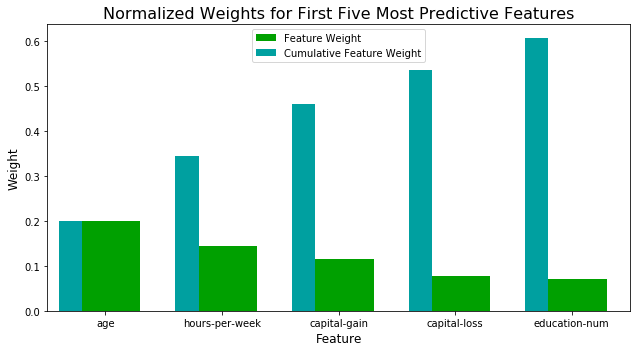

In [42]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = best_clf
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

I got four right: `education-num`, `capital-loss`, `capital-gain` and `hours-per-week`, from lowest to most important. Also, makes sense that `age` also plays an important role due to the fact that, as people progress on their careers, they usually end up having higher salaries. But since I had to choose five, I left it out (and it turned out to be the most important)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

**Addend**
Since I've changed the chosen model and I don't want to lose past implementations, I'm just gonna comment it out and duplicate to apply on `XGBoost`.

In [43]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8652
F-score on testing data: 0.7719

Final Model trained on reduced data
------
Accuracy on testing data: 0.8352
F-score on testing data: 0.6989


/home/rui/trampo/lib/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer**:

Reduced data gave out significantly worse performance than when using all of the features. That's because, even though our model sequentially re-weight the features on each iteration, being a sparse and unbalanced dataset, the relationship between features that are not highly weighted does have an impact on predictive power.

**Old Answer:**

~~The results on reduced data were actually worse.. But I think that might have to do with the fact that we used a different model to rank those features, i.e. `RandomForest`. In that way, those 5 features are relevant to classify the data *if we're using `RandomForest`*. Since our chosen model were `LogisticRegression`, I'm gonna try it out using the top 5 features the model itself classifies as having the most impact. In concern of training time, it's obvious that using a diminished feature space renders less time required for training. But it's a trade-off that's only worth it if it doesn't have significant impact on performance.~~

In [ ]:
feat_count = 10
feature_odds.sort(key=lambda k: k[1], reverse=True)
top_features = feature_odds[:feat_count]
top_features

In [ ]:
top_features_names = [ col[0] for col in top_features ]

X_train_reduced_logreg = X_train[top_features_names]
X_test_reduced_logreg = X_test[top_features_names]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced_logreg, y_train)

# Make new predictions
reduced_predictions_logreg = clf.predict(X_test_reduced_logreg)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions_logreg)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions_logreg, beta = 0.5)))

Well.. still worse results. I guess `LogisticRegression` is really made to be used *as-is* or I'm really missing something here. But the results, this time, were closer. Got only 1% less accuracy and F-score using just 10 features, instead of 98.  This time I think the trade-off is significantly good, if we had a larger volume of data that might have impacted more on training time.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.